In [201]:
from PIL import Image;
import numpy as np;
import matplotlib.pyplot as plt
from math import *

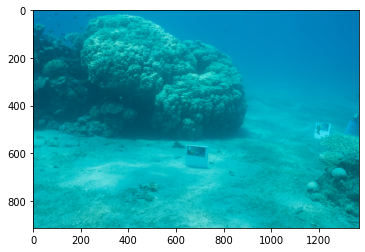

In [202]:
image = Image.open("../resources/image3_low.png")
plt.imshow(image)


In [203]:
width, height = image.size
imageArr = np.asarray(image)
imageArr.shape

(914, 1369, 3)

In [204]:
def plot_data(img, fig):
    ax = fig.add_subplot(projection='3d')
    ax.scatter(img[...,0].ravel(), 
                img[...,1].ravel(), 
                img[...,2].ravel(),
                c=img.reshape((-1,3))/255, 
                marker='.', 
                alpha=0.2)
    ax.set_xlabel("Red")
    ax.set_xlim3d(0, 255)
    ax.set_ylabel("Green")
    ax.set_ylim3d(0, 255)
    ax.set_zlabel("Blue")
    ax.set_zlim3d(0, 255)
    plt.title("Color distribution of our image")

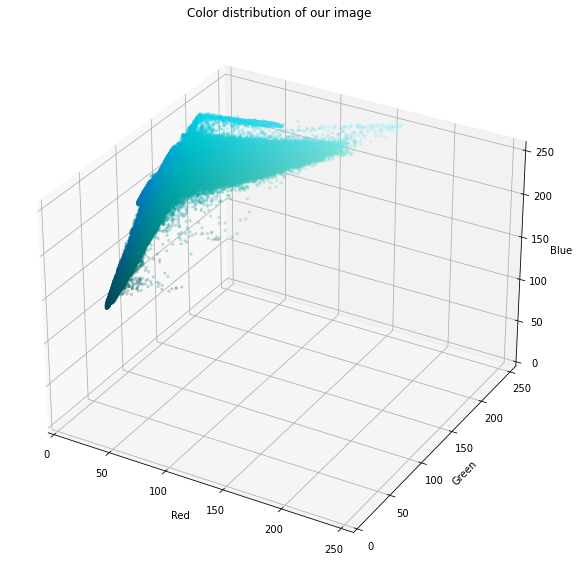

In [205]:
figure = plt.figure(figsize=(10,10))
plot_data(imageArr, figure)

In [206]:
def pickJerlovColors() :  
    image = np.asarray(Image.open("../resources/water_types.png"))[...,:3]
    height, width = image.shape[0], image.shape[1]
    deltaHeight = (int)(height / 6)
    deltaWidth = (int)(width / 20)
    colors = []
    for i in range(6):
        for j in range(20):
            colors.append(image[3+ i * deltaHeight][5 + j * deltaWidth])
    return np.array(colors)

In [207]:
def equalF(a, b):
    return abs(a - b) < 0.001

def rgbToHsv(color):
    r = color[0]/255.0
    g = color[1]/255.0
    b = color[2]/255.0
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    d = cmax - cmin
    h = 0
    if equalF(d, 0):
        h = 0
    elif equalF(cmax, r):
        h = 60 * ((g - b)/d % 6)
    elif equalF(cmax, g):
        h = 60 * ((b - r)/d + 2)
    elif equalF(cmax, b):
        h = 60 * ((r - g)/d + 4)
    s = 0
    if equalF(cmax, 0):
        s = 0
    else:
        s = d / cmax
    v = cmax
    return [h, s, v]

def hsvToRgb(color):
    H, S, V = color[0], color[1], color[2]
    C = S * V
    X = C * (1 - abs(((color[0] / 60) % 2) - 1))
    m = C - V
    r, g, b = 0, 0, 0
    if H >= 0 and H < 60:
        r, g, b = C, X, 0
    if H >= 60 and H < 120:
        r, g, b = X, C, 0
    if H >= 120 and H < 180:
        r, g, b = 0, C, X
    if H >= 180 and H < 240:
        r, g, b = 0, X, C
    if H >= 240 and H < 300:
        r, g, b = X, 0, C
    if H >= 300 and H < 360:
        r, g, b = C, 0, X
    return [int((r + m) * 255), int((g + m) * 255), int((b + m) * 255)]

In [208]:
def hsvDistance(c1, c2) :
    dh = min(abs(c1[0] - c2[0]), 360 - abs(c1[0] - c2[0]))
    ds = abs(c1[1] - c2[1])
    dv = abs(c1[2] - c2[2]) / 255.0
    return sqrt(dh * dh + ds * ds + dv * dv)

def score(arr):
    score = 0.0
    for i in range(0,3):
        score = score + 0.33 * (np.mean(arr[...,i]) - sqrt(np.var(arr[...,i])))
    jerlovColors = pickJerlovColors()
    meanColor = [np.mean(arr[...,0]), np.mean(arr[...,1]), np.mean(arr[...,2])]
    value = 1e10
    for jcolor in jerlovColors:
        dist = hsvDistance(rgbToHsv(jcolor), rgbToHsv(meanColor))
        if dist < value:
            value = dist
    return score - value

In [209]:
import matplotlib.patches as patches

def findBackground(arr, nbSplit = 4, debug=False):
    width, height = arr.shape[1], arr.shape[0]
    bestScore = 0
    bestCoords = (0,0)
    dw = (int)(width / nbSplit)
    dh = (int)(height / nbSplit)
    for i in range(0, nbSplit):
        for j in range(0, nbSplit):
            hmin, hmax = max(i * dh, 0), min((i + 1) * dh, height)
            wmin, wmax = max(j * dw, 0), min((j + 1) * dw, width)
            scoreZ = score(arr[hmin:hmax, wmin:wmax, ...])
            if (scoreZ > bestScore):
                bestScore = scoreZ
                bestCoords = (i, j)
    bestZone = arr[max((bestCoords[0]) * dh, 0):min((bestCoords[0] + 1)*dh, height), max((bestCoords[1])*dw, 0):min((bestCoords[1] + 1)*dw, width), ...]
    if (debug):
        print("Best area is " + str(bestCoords[0] + 1) + " " + str(bestCoords[1] + 1) + " with score " + str(bestScore))
        fig, ax = plt.subplots()
        ax.imshow(arr)
        rect = patches.Rectangle((max((bestCoords[1]) * dw, 0), max((bestCoords[0])*dh, 0)), dw, dh, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
    return [np.mean(bestZone[...,0]), np.mean(bestZone[...,1]), np.mean(bestZone[...,2])]
            


Best area is 7 2 with score 119.05488267644142


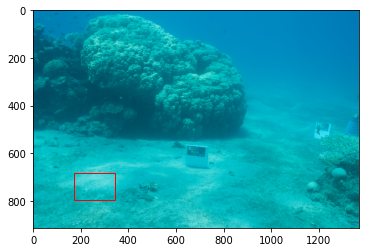

[37.95147224787114, 198.01703088129682, 201.08417974761466]


In [302]:
A = findBackground(imageArr, nbSplit = 8, debug=True)
print(A)

https://mdpi-res.com/d_attachment/jmse/jmse-10-00430/article_deploy/jmse-10-00430.pdf?version=1647354296

In [318]:
def surround_gauss_kernel(size: int, scale) -> np.array:
    size = int(size)
    y, x = np.mgrid[-size:size+1, -size:size+1]
    norm = 1 / (2 * np.pi * scale**2)

    g = np.exp(-(np.square(x) + np.square(y) / (2 * (scale ** 2))))
    
    return g * norm

In [323]:
from scipy.signal import convolve
Lr = convolve(imageArr[...,0], surround_gauss_kernel(5, 15), mode='same', method='direct') - convolve(imageArr[...,0], surround_gauss_kernel(5, 10), mode='same', method='direct')
Lr[Lr == 0] = 0.1
Lg = convolve(imageArr[...,1], surround_gauss_kernel(5, 15), mode='same', method='direct') - convolve(imageArr[...,1], surround_gauss_kernel(5, 10), mode='same', method='direct')
Lg[Lg == 0] = 0.1
Lb = convolve(imageArr[...,2], surround_gauss_kernel(5, 15), mode='same', method='direct') - convolve(imageArr[...,2], surround_gauss_kernel(5, 10), mode='same', method='direct')
Lb[Lb == 0] = 0.1

In [ ]:
outputIm = np.stack((Lr, Lg, Lb), axis=-1)
plt.imshow(outputIm)

In [324]:
tr = ((imageArr[...,0] - A[0]) * Lr) / (imageArr[...,0] - A[0] * Lr)
tg = ((imageArr[...,1] - A[1]) * Lg) / (imageArr[...,1] - A[1] * Lg)
tb = ((imageArr[...,2] - A[2]) * Lb) / (imageArr[...,2] - A[2] * Lb)

In [325]:
outputr = (imageArr[...,0] - A[0]) / tr + A[0]
outputr = (outputr - np.min(outputr)) / (np.max(outputr) - np.min(outputr))
outputg = (imageArr[...,1] - A[1]) / tg + A[1]
outputg = (outputg - np.min(outputg)) / (np.max(outputg) - np.min(outputg))
outputb = (imageArr[...,2] - A[2]) / tb + A[2]
outputb = (outputb - np.min(outputb)) / (np.max(outputb) - np.min(outputb))

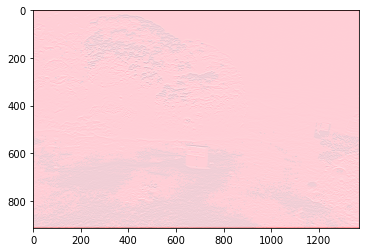

In [326]:
outputIm = np.stack((outputr, outputg, outputb), axis=-1)
plt.imshow(outputIm)